In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


LINEAR DIFFUSION MODEL 30 EPOCHS

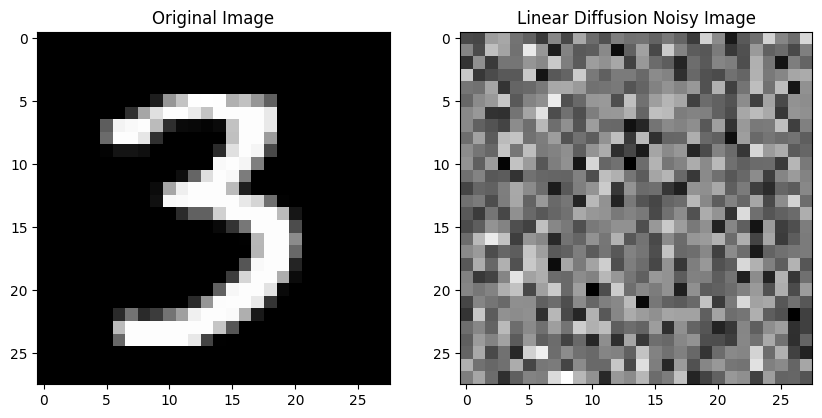

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.7998 - loss: 0.2992
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - accuracy: 0.7951 - loss: 0.2459
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7952 - loss: 0.2426
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7947 - loss: 0.2412
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7950 - loss: 0.2400
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7948 - loss: 0.2392
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.7947 - loss: 0.2384
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7943 - loss: 0.2377
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.7947 - loss: 0.2363
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7941 - loss: 0.2356
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.7949 - loss: 0.2338
Epoch 12/30
469/469 ━━━━━━━━━━

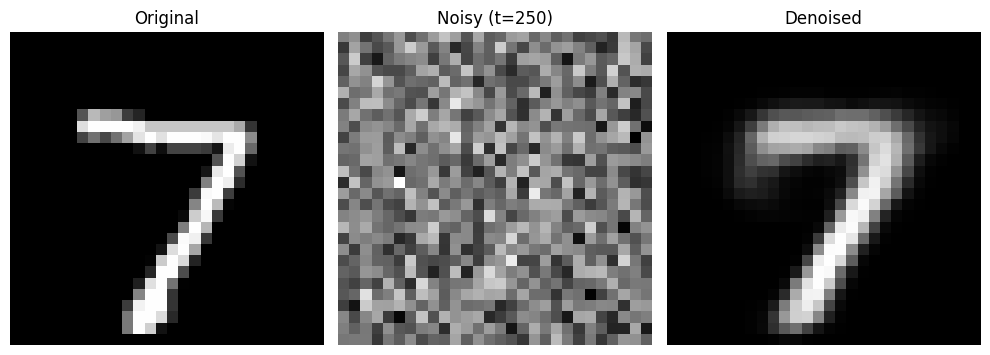

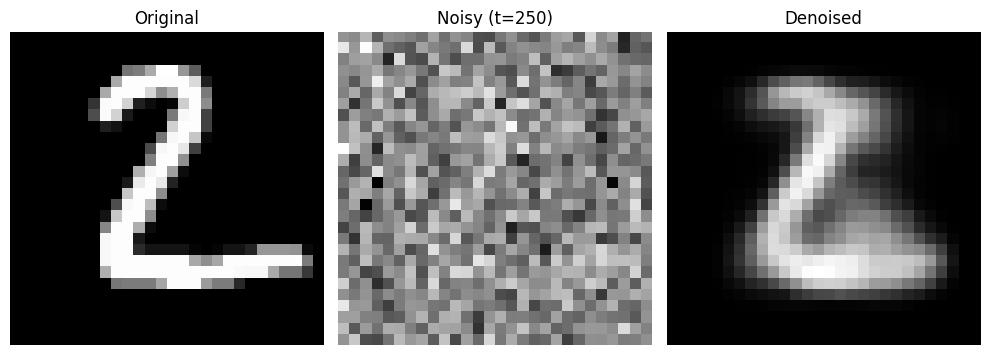

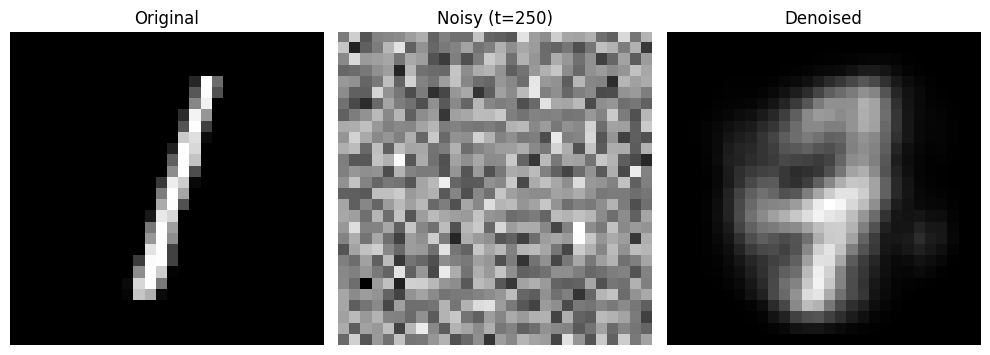

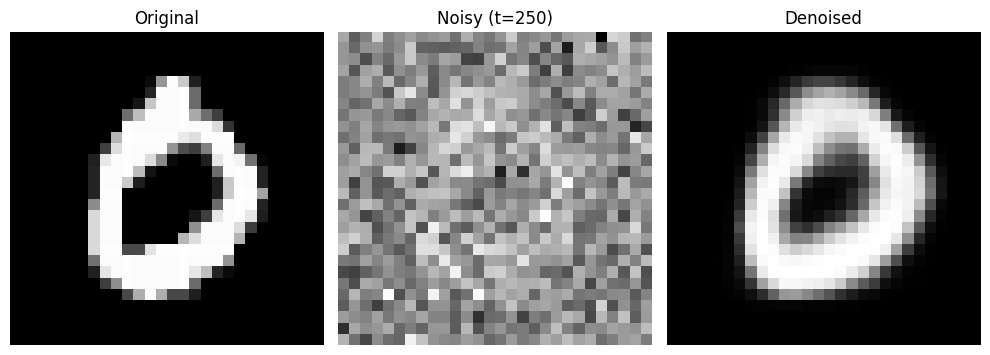

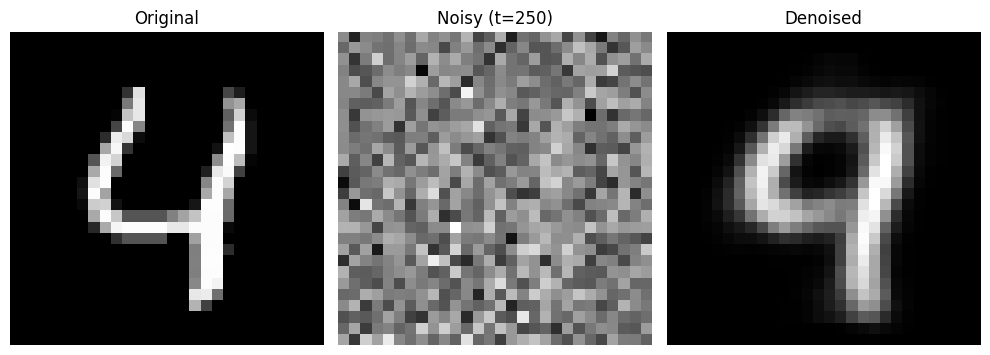

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test Performance at timestep 500: loss=0.2728, acc=0.7821


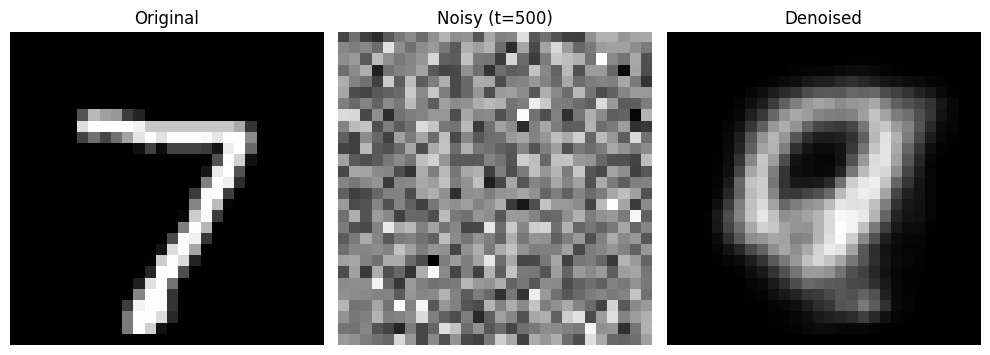

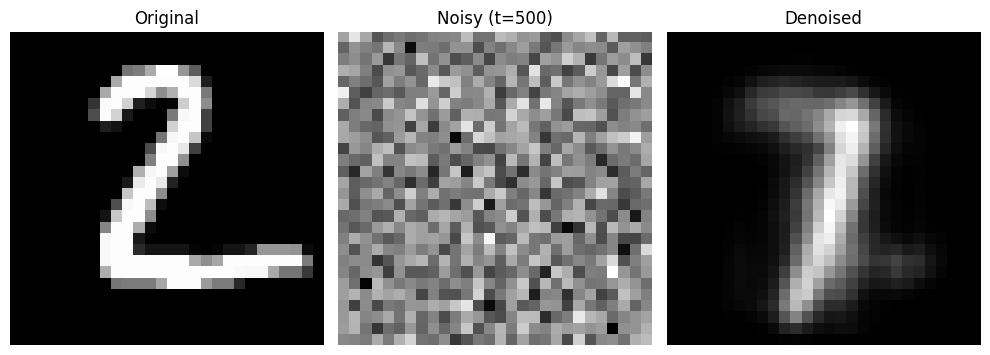

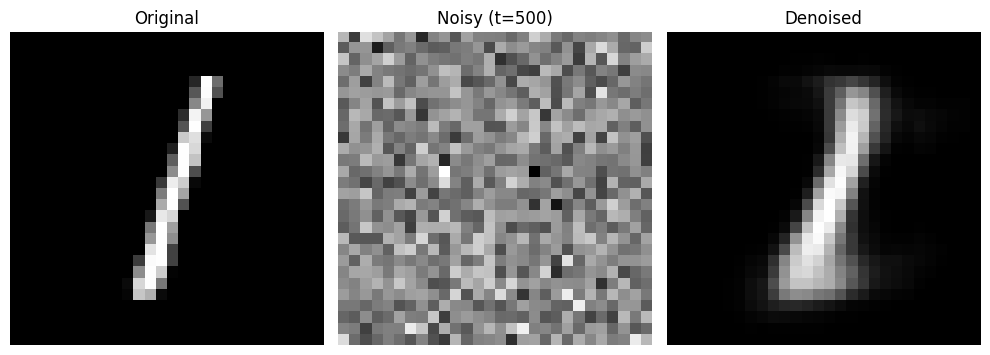

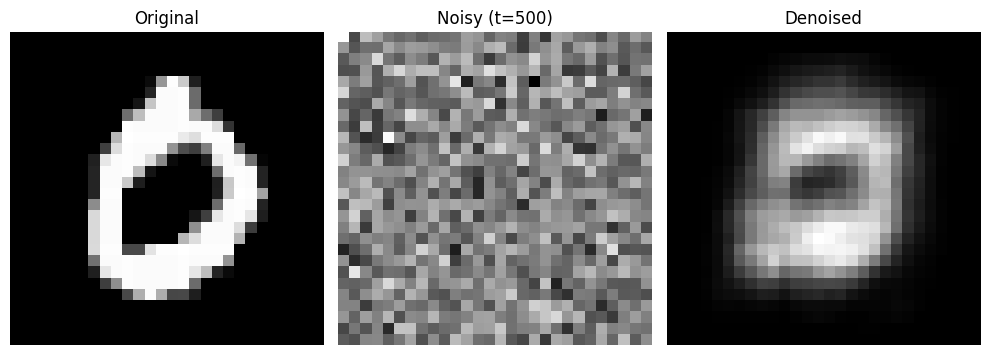

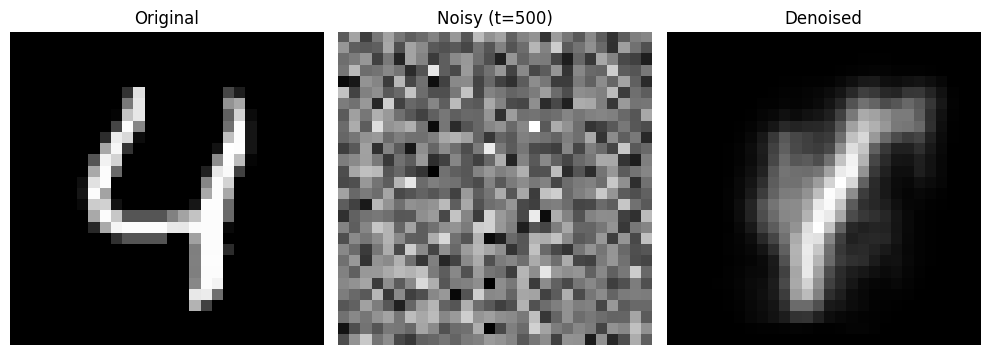

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Performance at timestep 800: loss=0.3332, acc=0.7819


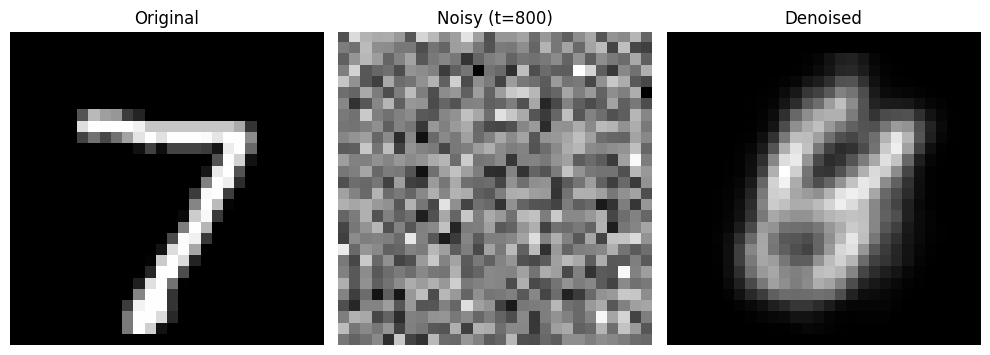

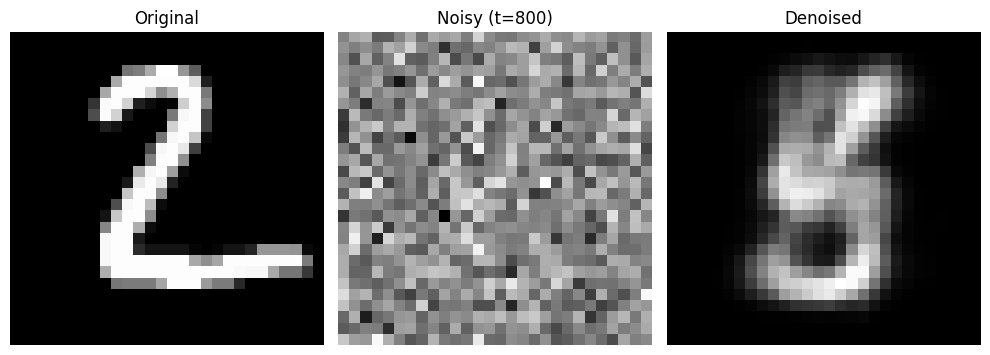

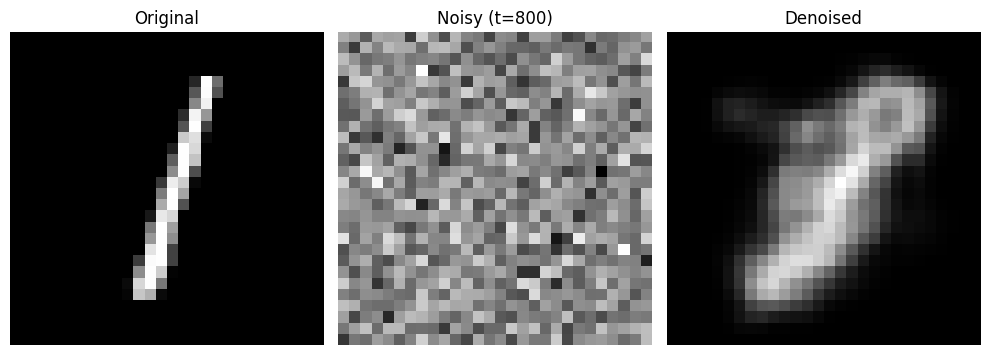

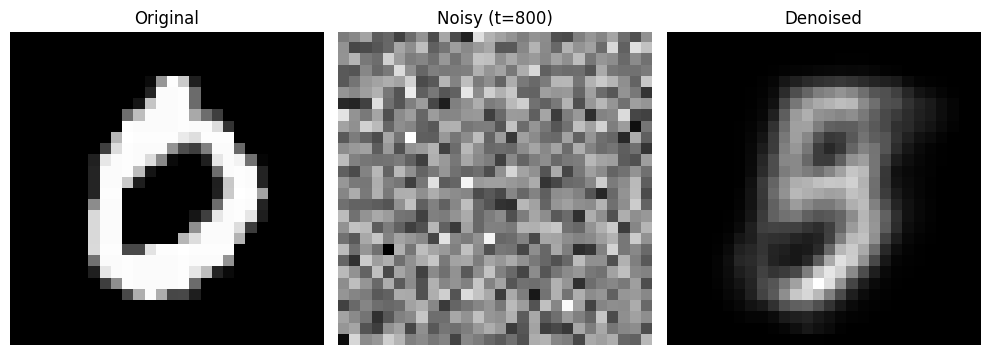

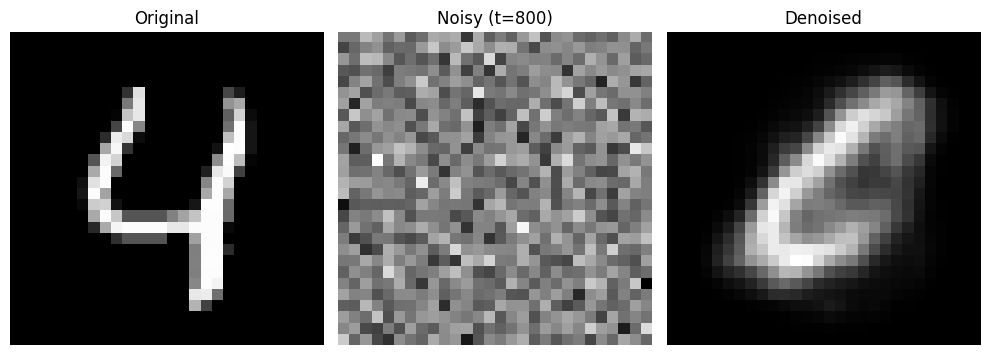

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Load MNIST
(X_train, _), (X_test, _) = mnist.load_data()

# Normalize
X_train = X_train / 255.
X_test = X_test / 255.

# Reshape
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Linear beta schedule and forward diffusion function
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return np.linspace(beta_start, beta_end, timesteps)

T = 1000
betas = linear_beta_schedule(T)
alphas = 1. - betas
alpha_bars = np.cumprod(alphas)

def q_sample(x_start, t, alpha_bars):
    # Add noise to the input x_start at timestep t using DDPM's q(x_t | x_0)
    sqrt_alpha_bar = np.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = np.sqrt(1 - alpha_bars[t])[:, None, None, None]
    noise = np.random.randn(*x_start.shape)
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

# Generate noisy training data using linear diffusion at timestep t=500
t_train = np.full((X_train.shape[0],), 500)
X_train_noisy = q_sample(X_train, t_train, alpha_bars)

# Display example
n = 10000
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(X_train[n], cmap='gray')
ax[1].imshow(X_train_noisy[n], cmap='gray')
ax[0].set_title("Original Image")
ax[1].set_title("Linear Diffusion Noisy Image")
plt.show()

# Define autoencoder model (U-Net-like)
input_shape = (28, 28, 1)
inputs = Input(input_shape)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up4 = UpSampling2D((2, 2))(conv3)
up4 = Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
merge4 = concatenate([conv2, up4], axis=3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up5 = UpSampling2D((2, 2))(conv4)
up5 = Conv2D(32, (2, 2), activation='relu', padding='same')(up5)
merge5 = concatenate([conv1, up5], axis=3)

conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_noisy, X_train, epochs=30, batch_size=128, shuffle=True, verbose=1)

# --- Test the model on various diffusion timesteps ---

def test_denoising_at_timestep(t_val):
    t_test = np.full((X_test.shape[0],), t_val)
    X_test_noisy = q_sample(X_test, t_test, alpha_bars)
    denoised = model.predict(X_test_noisy)
    loss, acc = model.evaluate(X_test_noisy, X_test, verbose=0)
    print(f"Test Performance at timestep {t_val}: loss={loss:.4f}, acc={acc:.4f}")

    for i in range(2):
        fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(X_test[i], cmap='gray')
        ax[1].imshow(X_test_noisy[i], cmap='gray')
        ax[2].imshow(denoised[i], cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].set_title(f"Noisy (t={t_val})")
        ax[2].set_title("Denoised Image")
        plt.show()










import os
from PIL import Image

# Define your directories (update these with your desired paths)
original_dir = '/content/drive/MyDrive/NLP FINAL/linear original'
noisy_dir = '/content/drive/MyDrive/NLP FINAL/linear noisy'
denoised_dir = '/content/drive/MyDrive/NLP FINAL/linear denoised'

# Ensure directories exist
os.makedirs(original_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(denoised_dir, exist_ok=True)

def save_image(img_array, path):
    # Convert to uint8 and save using PIL
    img = (img_array * 255).astype(np.uint8).squeeze()
    img = Image.fromarray(img)
    img.save(path)

def test_denoising_at_timestep(t_val):
    t_test = np.full((X_test.shape[0],), t_val)
    X_test_noisy = q_sample(X_test, t_test, alpha_bars)
    denoised = model.predict(X_test_noisy)
    loss, acc = model.evaluate(X_test_noisy, X_test, verbose=0)
    print(f"Test Performance at timestep {t_val}: loss={loss:.4f}, acc={acc:.4f}")

    # Save only the first 5 samples
    for i in range(5):
        save_image(X_test[i], os.path.join(original_dir, f't{t_val}_img_{i}_original.png'))
        save_image(X_test_noisy[i], os.path.join(noisy_dir, f't{t_val}_img_{i}_noisy.png'))
        save_image(denoised[i], os.path.join(denoised_dir, f't{t_val}_img_{i}_denoised.png'))

    # Visualize those 5
    for i in range(5):
        fig, ax = plt.subplots(1, 3, figsize=(10, 4))
        ax[0].imshow(X_test[i].squeeze(), cmap='gray')
        ax[1].imshow(X_test_noisy[i].squeeze(), cmap='gray')
        ax[2].imshow(denoised[i].squeeze(), cmap='gray')
        ax[0].set_title("Original")
        ax[1].set_title(f"Noisy (t={t_val})")
        ax[2].set_title("Denoised")
        for a in ax: a.axis('off')
        plt.tight_layout()
        plt.show()



# Test at 50%, 65%, and 80% noise levels roughly corresponding to t=250, 500, 800
test_denoising_at_timestep(250)
test_denoising_at_timestep(500)
test_denoising_at_timestep(800)


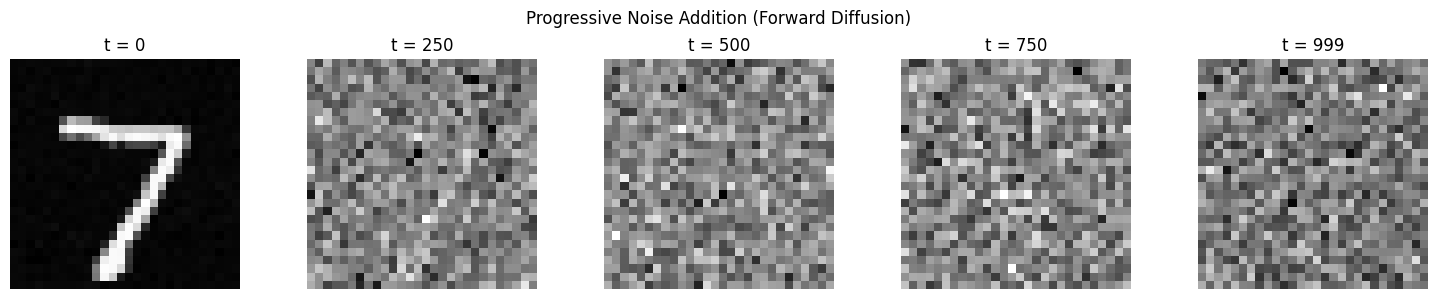

In [ ]:
# Define timesteps to visualize
timesteps_to_visualize = [0, 250, 500, 750, 999]

# Choose an index from test set
idx = 0
original = X_test[idx]

# Plot progressive noise
fig, axes = plt.subplots(1, len(timesteps_to_visualize), figsize=(15, 3))
for i, t in enumerate(timesteps_to_visualize):
    t_array = np.full((1,), t)
    noisy_img = q_sample(np.expand_dims(original, axis=0), t_array, alpha_bars)[0]

    axes[i].imshow(noisy_img.squeeze(), cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')

plt.suptitle("Progressive Noise Addition (Forward Diffusion)")
plt.tight_layout()
plt.show()


NON LINEAR DIFFUSION MODEL 30 EPOCHS

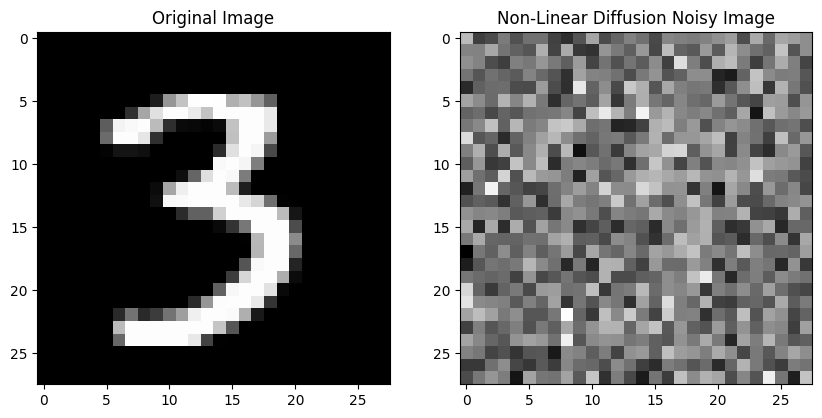

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.7957 - loss: 0.2267
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8070 - loss: 0.1425
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.8074 - loss: 0.1364
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8083 - loss: 0.1325
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8087 - loss: 0.1303
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.8086 - loss: 0.1289
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8088 - loss: 0.1274
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8089 - loss: 0.1262
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8094 - loss: 0.1248
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8095 - loss: 0.1241
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.8095 - loss: 0.1231
Epoch 12/30
469/469 ━━━━━━━━━━

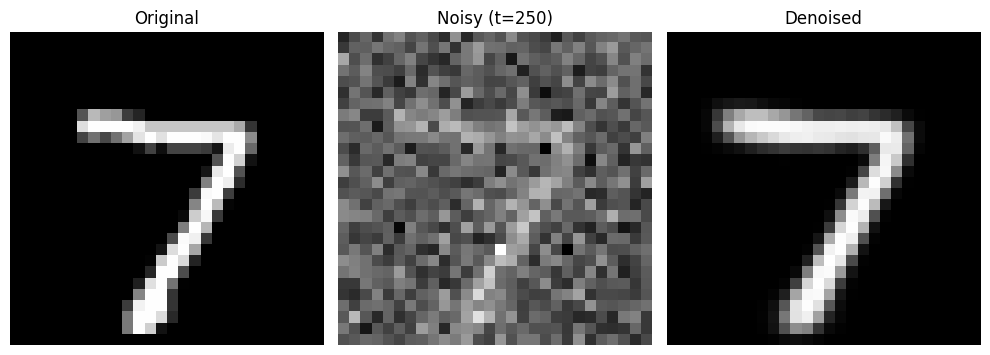

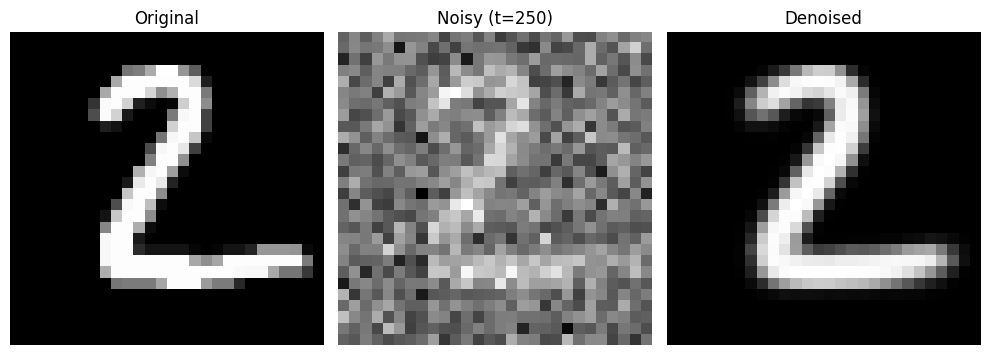

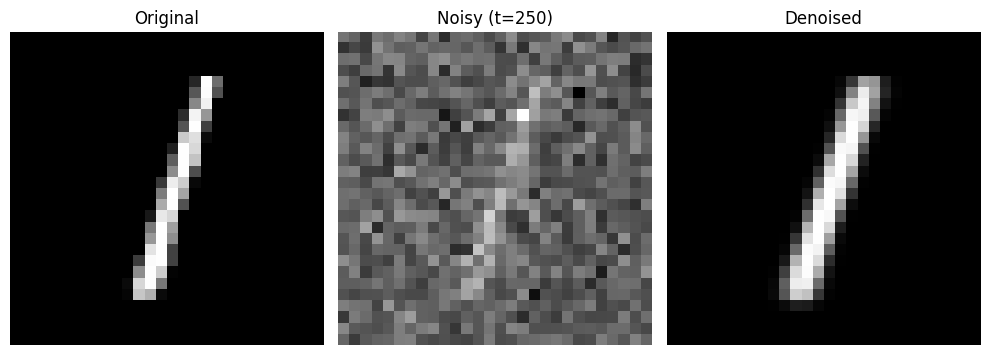

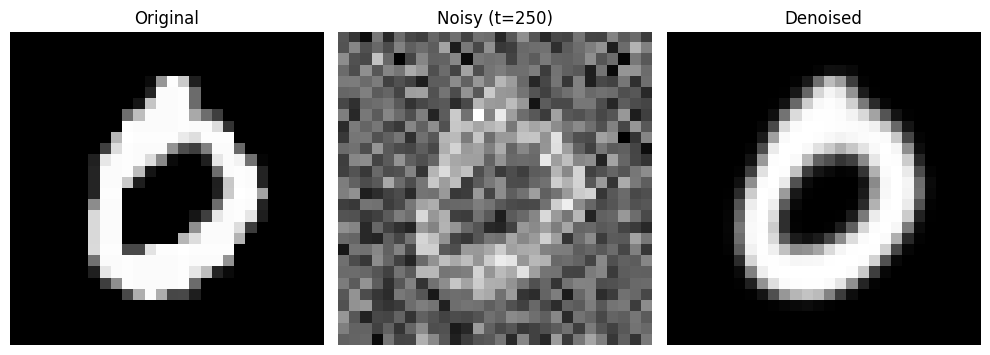

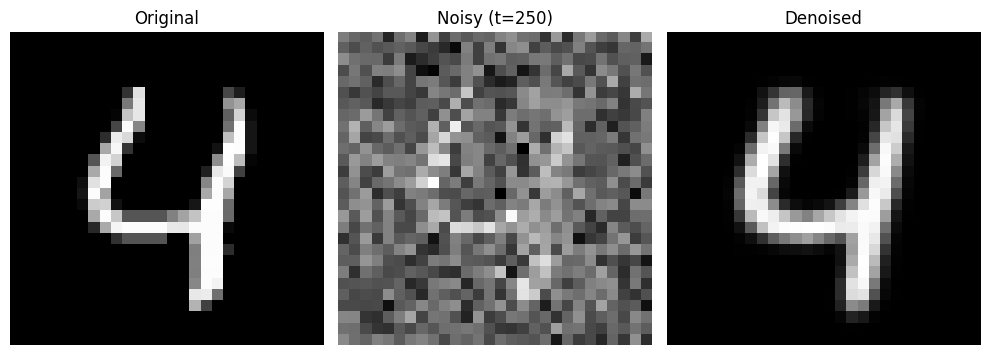

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Performance at timestep 500: loss=0.1353, acc=0.8055


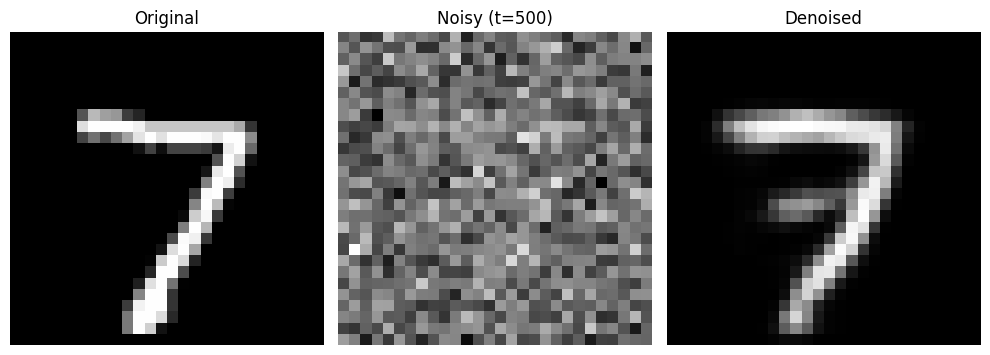

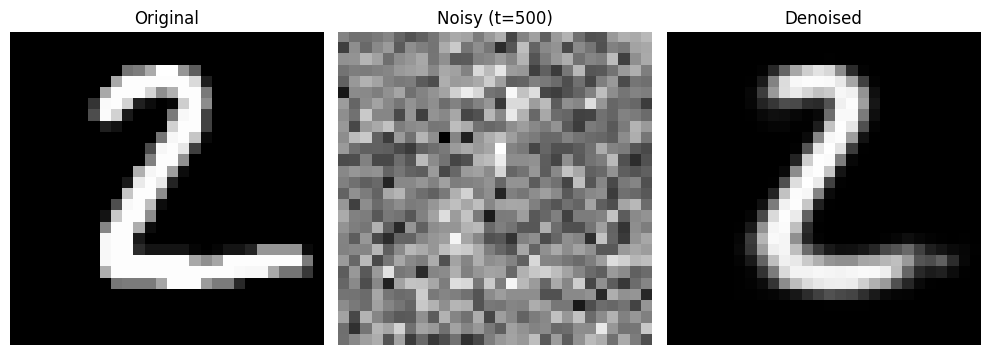

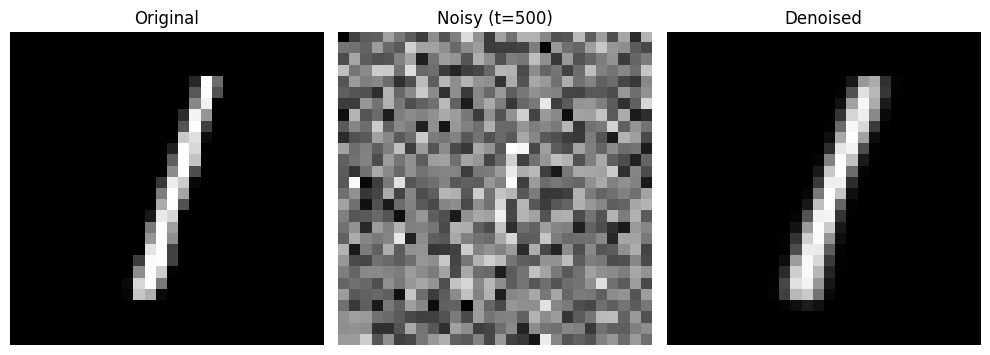

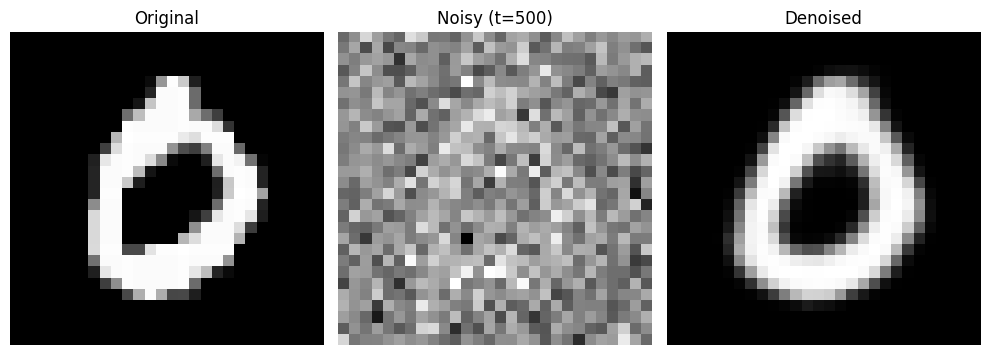

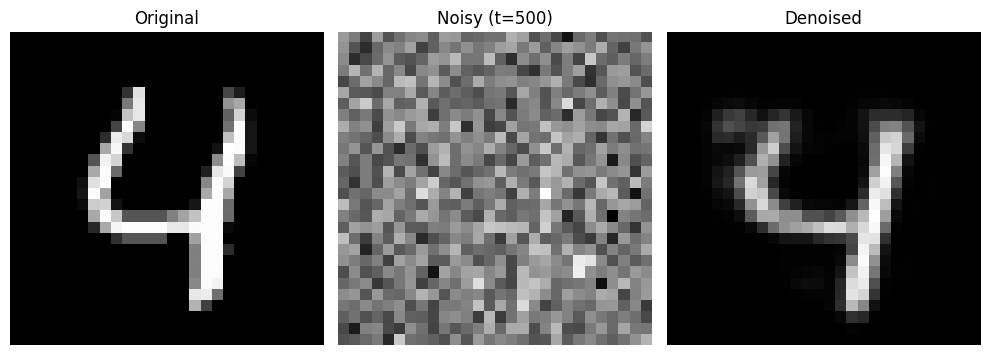

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Performance at timestep 800: loss=0.3676, acc=0.7841


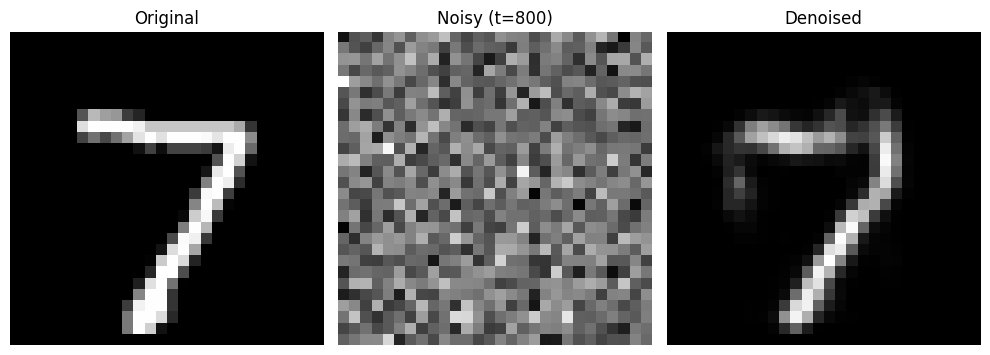

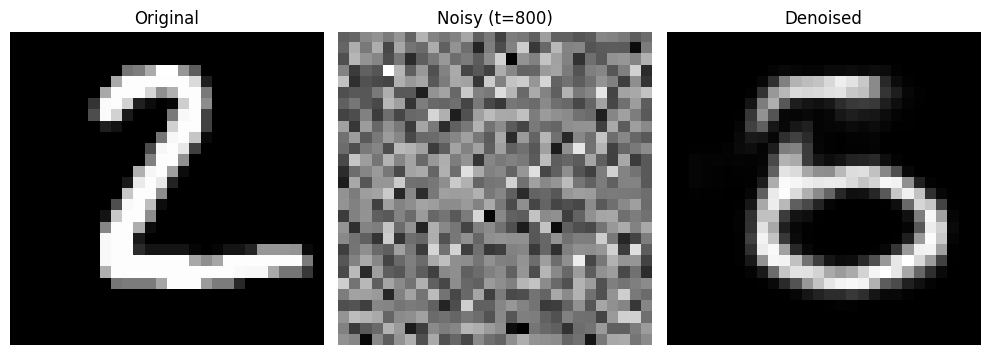

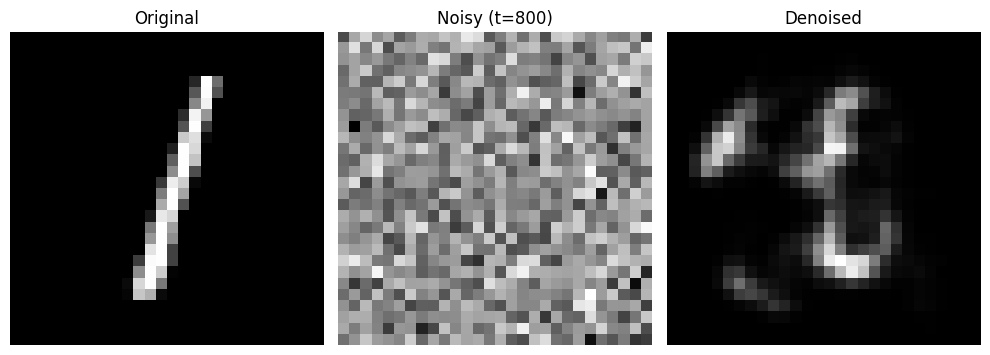

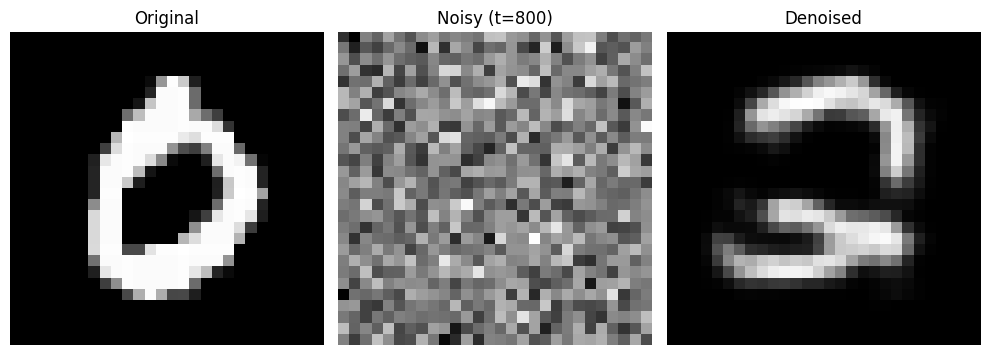

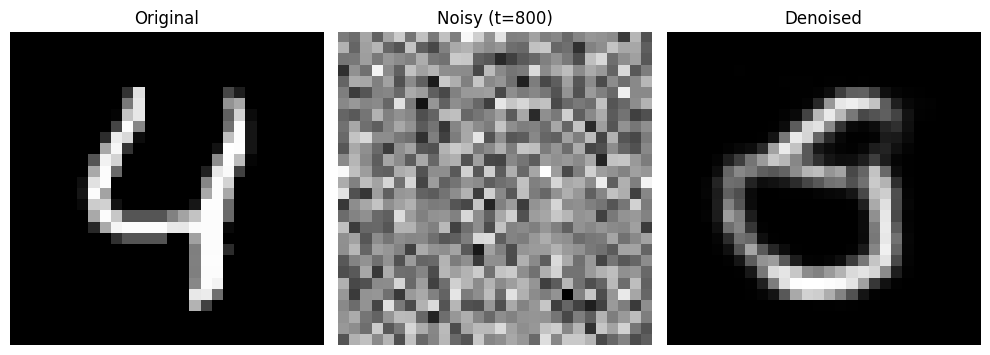

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

# Load MNIST
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train / 255.
X_test = X_test / 255.
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# --- Cosine Beta Schedule (Non-linear Diffusion) ---
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 1e-7, 0.999)

# Forward process using cosine-based alphas
T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alpha_bars = np.cumprod(alphas)

def q_sample(x_start, t, alpha_bars):
    sqrt_alpha_bar = np.sqrt(alpha_bars[t])[:, None, None, None]
    sqrt_one_minus_alpha_bar = np.sqrt(1 - alpha_bars[t])[:, None, None, None]
    noise = np.random.randn(*x_start.shape)
    return sqrt_alpha_bar * x_start + sqrt_one_minus_alpha_bar * noise

# Generate noisy training data using cosine noise at timestep 500
t_train = np.full((X_train.shape[0],), 500)
X_train_noisy = q_sample(X_train, t_train, alpha_bars)

# Visualize example
n = 10000
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(X_train[n], cmap='gray')
ax[1].imshow(X_train_noisy[n], cmap='gray')
ax[0].set_title("Original Image")
ax[1].set_title("Non-Linear Diffusion Noisy Image")
plt.show()

# --- Autoencoder Model ---
input_shape = (28, 28, 1)
inputs = Input(input_shape)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up4 = UpSampling2D((2, 2))(conv3)
up4 = Conv2D(64, (2, 2), activation='relu', padding='same')(up4)
merge4 = concatenate([conv2, up4], axis=3)

conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up5 = UpSampling2D((2, 2))(conv4)
up5 = Conv2D(32, (2, 2), activation='relu', padding='same')(up5)
merge5 = concatenate([conv1, up5], axis=3)

conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- Train Model ---
history = model.fit(X_train_noisy, X_train, epochs=30, batch_size=128, shuffle=True, verbose=1)

# --- Evaluate on Different Timesteps ---
def test_denoising_at_timestep(t_val):
    t_test = np.full((X_test.shape[0],), t_val)
    X_test_noisy = q_sample(X_test, t_test, alpha_bars)
    denoised = model.predict(X_test_noisy)
    loss, acc = model.evaluate(X_test_noisy, X_test, verbose=0)
    print(f"Test Performance at timestep {t_val}: loss={loss:.4f}, acc={acc:.4f}")

    for i in range(2):
        fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(X_test[i], cmap='gray')
        ax[1].imshow(X_test_noisy[i], cmap='gray')
        ax[2].imshow(denoised[i], cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].set_title(f"Noisy (t={t_val})")
        ax[2].set_title("Denoised Image")
        plt.show()


import os
from PIL import Image

# Define save directories
original_dir = '/content/drive/MyDrive/NLP FINAL/non linear original'
noisy_dir = '/content/drive/MyDrive/NLP FINAL/non linear noisy'
denoised_dir = '/content/drive/MyDrive/NLP FINAL/non linear denoised'

os.makedirs(original_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(denoised_dir, exist_ok=True)

def save_image(img_array, path):
    img = (img_array * 255).astype(np.uint8).squeeze()
    img = Image.fromarray(img)
    img.save(path)

def test_denoising_at_timestep(t_val):
    t_test = np.full((X_test.shape[0],), t_val)
    X_test_noisy = q_sample(X_test, t_test, alpha_bars)
    denoised = model.predict(X_test_noisy)
    loss, acc = model.evaluate(X_test_noisy, X_test, verbose=0)
    print(f"Test Performance at timestep {t_val}: loss={loss:.4f}, acc={acc:.4f}")

    for i in range(5):  # Save first 5 samples
        save_image(X_test[i], os.path.join(original_dir, f't{t_val}_img_{i}_original.png'))
        save_image(X_test_noisy[i], os.path.join(noisy_dir, f't{t_val}_img_{i}_noisy.png'))
        save_image(denoised[i], os.path.join(denoised_dir, f't{t_val}_img_{i}_denoised.png'))

        # Optional: Show side-by-side
        fig, ax = plt.subplots(1, 3, figsize=(10, 4))
        ax[0].imshow(X_test[i].squeeze(), cmap='gray')
        ax[1].imshow(X_test_noisy[i].squeeze(), cmap='gray')
        ax[2].imshow(denoised[i].squeeze(), cmap='gray')
        ax[0].set_title("Original")
        ax[1].set_title(f"Noisy (t={t_val})")
        ax[2].set_title("Denoised")
        for a in ax: a.axis('off')
        plt.tight_layout()
        plt.show()





# Evaluate at multiple noise levels
test_denoising_at_timestep(250)
test_denoising_at_timestep(500)
test_denoising_at_timestep(800)


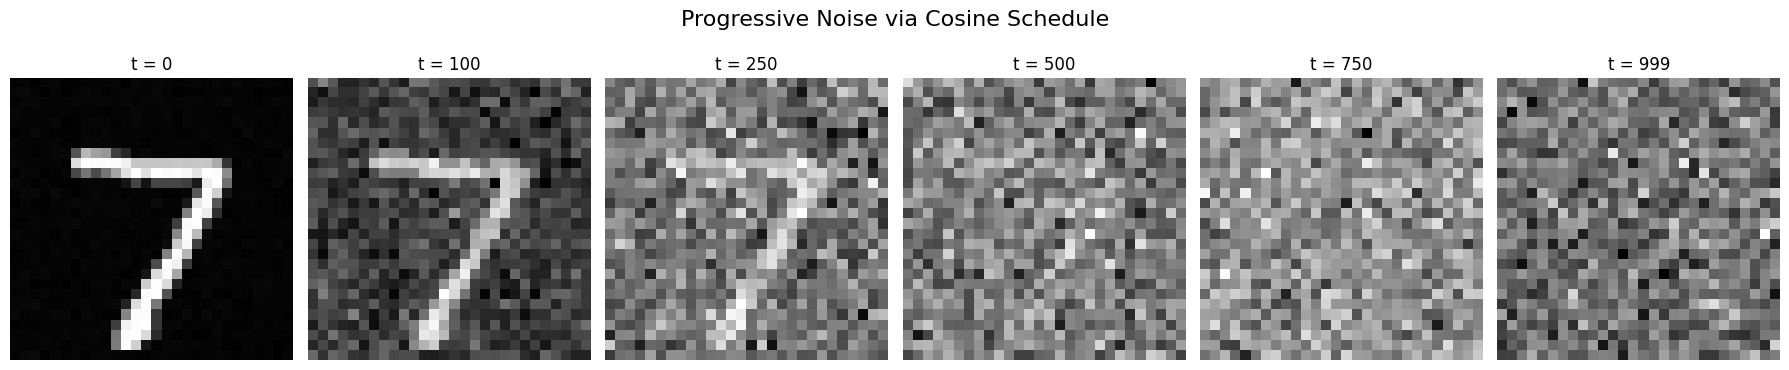

In [ ]:
def visualize_progressive_noise(image_idx=0, timesteps=[0, 100, 250, 500, 750, 999]):
    fig, axes = plt.subplots(1, len(timesteps), figsize=(18, 4))
    x_start = X_test[image_idx:image_idx+1]  # shape: (1, 28, 28, 1)

    for i, t in enumerate(timesteps):
        t_batch = np.array([t])
        noisy_img = q_sample(x_start, t_batch, alpha_bars)
        axes[i].imshow(noisy_img[0].squeeze(), cmap='gray')
        axes[i].set_title(f"t = {t}")
        axes[i].axis('off')

    plt.suptitle("Progressive Noise via Cosine Schedule", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage
visualize_progressive_noise(image_idx=0)


RESULT ANALYSIS
1. Compute image quality metrics like PSNR, SSIM, or LPIPS between original and denoised images.

2. Evaluate mode collapse by checking how similar the generated (denoised) images are to each other.

3. Assess diversity using perceptual distances (e.g., LPIPS), variance across embeddings, or Inception Score/FID.

In [ ]:
pip install lpips scikit-image torch torchvision matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 188MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth

--- Image Quality ---


100%|██████████| 15/15 [00:00<00:00, 77.60it/s]


Linear - PSNR: 14.16, SSIM: 0.511, LPIPS: 0.314
Nonlinear - PSNR: 18.57, SSIM: 0.749, LPIPS: 0.163

--- Diversity (lower means mode collapse) ---


100%|██████████| 105/105 [00:01<00:00, 91.16it/s]


Linear Diversity (LPIPS mean): 0.230
Nonlinear Diversity (LPIPS mean): 0.346


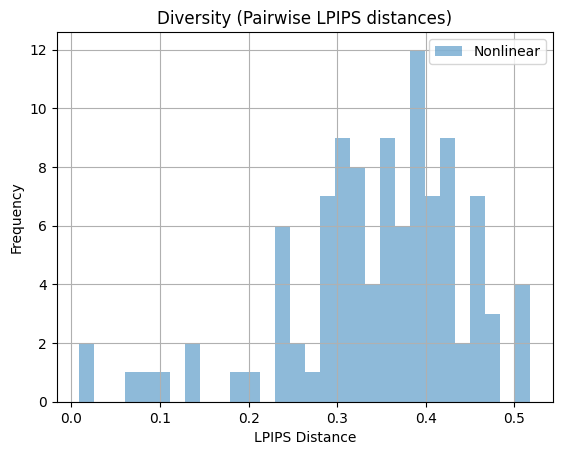

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torchvision.transforms as T
import lpips
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
from itertools import combinations

# Set paths
original_dir = '/content/drive/MyDrive/NLP FINAL/linear original'
linear_dir = '/content/drive/MyDrive/NLP FINAL/linear denoised'
nonlinear_dir = '/content/drive/MyDrive/NLP FINAL/non linear denoised'

# Image transform
transform = T.Compose([
    T.Resize((96, 96)),  # Adjust if necessary
    T.ToTensor(),
])

# LPIPS model
lpips_model = lpips.LPIPS(net='alex')

def load_image(path):
    return transform(Image.open(path).convert('RGB'))

def compare_images(originals, denoised):
    psnr_list = []
    ssim_list = []
    lpips_list = []

    for orig, den in tqdm(zip(originals, denoised), total=len(originals)):
        orig_np = orig.permute(1, 2, 0).numpy()
        den_np = den.permute(1, 2, 0).numpy()

        psnr_list.append(psnr(orig_np, den_np, data_range=1.0))
        ssim_list.append(ssim(orig_np, den_np, channel_axis=2, data_range=1.0))

        with torch.no_grad():
            lp = lpips_model(orig.unsqueeze(0), den.unsqueeze(0))
            lpips_list.append(lp.item())

    return {
        'psnr': np.mean(psnr_list),
        'ssim': np.mean(ssim_list),
        'lpips': np.mean(lpips_list)
    }

def calculate_diversity(images):
    dists = []
    for img1, img2 in tqdm(combinations(images, 2), total=len(images)*(len(images)-1)//2):
        with torch.no_grad():
            dist = lpips_model(img1.unsqueeze(0), img2.unsqueeze(0))
            dists.append(dist.item())
    return np.mean(dists), dists

# Load images
def load_all_images(folder):
    images = []
    files = sorted(os.listdir(folder))
    for fname in files:
        path = os.path.join(folder, fname)
        images.append(load_image(path))
    return images

# Load all sets
originals = load_all_images(original_dir)
linear = load_all_images(linear_dir)
nonlinear = load_all_images(nonlinear_dir)

# Quality comparison
print("\n--- Image Quality ---")
linear_quality = compare_images(originals, linear)
nonlinear_quality = compare_images(originals, nonlinear)

print(f"Linear - PSNR: {linear_quality['psnr']:.2f}, SSIM: {linear_quality['ssim']:.3f}, LPIPS: {linear_quality['lpips']:.3f}")
print(f"Nonlinear - PSNR: {nonlinear_quality['psnr']:.2f}, SSIM: {nonlinear_quality['ssim']:.3f}, LPIPS: {nonlinear_quality['lpips']:.3f}")

# Diversity (in denoised images)
print("\n--- Diversity (lower means mode collapse) ---")
linear_diversity, _ = calculate_diversity(linear)
nonlinear_diversity, _ = calculate_diversity(nonlinear)

print(f"Linear Diversity (LPIPS mean): {linear_diversity:.3f}")
print(f"Nonlinear Diversity (LPIPS mean): {nonlinear_diversity:.3f}")

# Optional: plot distribution of pairwise LPIPS
plt.hist(_, bins=30, alpha=0.5, label='Nonlinear' if len(_) == len(nonlinear)*(len(nonlinear)-1)//2 else 'Linear')
plt.title('Diversity (Pairwise LPIPS distances)')
plt.xlabel('LPIPS Distance')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()


| Metric    | Linear | Nonlinear | Interpretation                                            |
| --------- | ------ | --------- | --------------------------------------------------------- |
| **PSNR**  | 14.16  | **18.57** | Higher is better — nonlinear has less noise.              |
| **SSIM**  | 0.511  | **0.749** | Higher is better — nonlinear better preserves structure.  |
| **LPIPS** | 0.314  | **0.163** | Lower is better — nonlinear is more perceptually similar. |



*   Non-linear is significantly better in all image quality metrics.



| Metric                    | Linear | Nonlinear | Interpretation                                                     |
| ------------------------- | ------ | --------- | ------------------------------------------------------------------ |
| **LPIPS (mean pairwise)** | 0.230  | **0.346** | Higher means more diverse — nonlinear avoids mode collapse better. |


*    Non-linear generates a more diverse set of outputs, indicating less mode collapse.





 Conclusion
The non-linear diffusion model outperforms the linear model in:

*   Reconstruction fidelity (PSNR, SSIM, LPIPS vs. original)
*   Perceptual quality
*   Diversity (less mode collapse)
